<a href="https://www.kaggle.com/code/les1781/predicting-loan-payback-playground-series-s5e11?scriptVersionId=274374412" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Loan Payback

### Playground Series - Season 5, Episode 11

### Your Goal: 

Predict the probability that a borrower will pay back their loan.

### Evaluation: 

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Submission File: 

For each id in the test set, you must predict a probability for the loan_paid_back variable. The file should contain a header and have the following format:

    id,loan_paid_back
    593994,0.5
    593995,0.2
    593996,0.1
    etc.

### Timeline:

- Start Date - November 1, 2025
- Entry Deadline - Same as the Final Submission Deadline
- Team Merger Deadline - Same as the Final Submission Deadline
- Final Submission Deadline - November 30, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

# Libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Initial analysis

We'll start by loading the training data, and taking a first look to see what variables we have for this problem, as well as the number of samples.

In [3]:
# We load the data

lpb_train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv", index_col="id")

In [4]:
print("Train data shape:", lpb_train.shape)

Train data shape: (593994, 12)


In [5]:
lpb_train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
lpb_train.describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [7]:
lpb_train.describe(exclude=np.number)

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
count,593994,593994,593994,593994,593994,593994
unique,3,4,5,5,8,30
top,Female,Single,Bachelor's,Employed,Debt consolidation,C3
freq,306175,288843,279606,450645,324695,58695


In [8]:
lpb_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 58.9+ MB


We encountered a binary classification problem, with our target variable "loan_paid_back" and 11 features (5 numeric and 6 categorical). Regarding the number of samples, we had a total of 593994 for training. For the numeric variables, we can observe quite wide and diverse ranges of values, therefore, an analysis of their distributions will be important to detect possible outliers. On the other hand, the categorical variables, with the exception of two of them that contain a high number of unique values, range from 3 to 5 unique values. We will proceed to exploratory data analysis, where we can explore the dataset in more depth.

# EDA

We will begin by creating some useful functions to analyze each variable in depth.

In [9]:
# Establishing the seaborn aesthetic

sns.set_style("darkgrid")

# We establish the color palette

palette = sns.set_palette("Greens_r")

In [10]:
# Function to analyze number distributions

def plot_number_analyzer(data, column, figsize, suptitle):

    print(
    "Variable: ", column,
    "\nFormat: ", data[column].dtype,
    "\nNumber of null values: ", data[column].isnull().sum(),
    "\nUnique values: ", data[column].nunique(),
    "\nVariable range:", data[column].min(), "to", data[column].max(), "\n\n"
    )

    # We graph the distribution
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    sns.histplot(
        data=data, 
        x=column, 
        palette=palette,
        edgecolor="k",
        ax=axes[0]
    )
    sns.boxplot(
        data=data, 
        x=column,
        palette=palette,
        ax=axes[1]
    )
    plt.suptitle(t=suptitle)
    plt.tight_layout()
    plt.show()

In [11]:
# Function for categorical variables

def plot_categories(data, figsize, sizes, labels, colors, explode, title):

    print(
    "\nNumber of null values: ", data.isnull().sum(),
    "\nUnique values: ", data.nunique(),
    "\nDistribution of values: \n", data.value_counts(), "\n\n"
    )

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    axes[0].pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors,
        wedgeprops={"edgecolor" : "k"},
        explode=explode,
        textprops={'fontsize': 12}
    )
    axes[0].set_ylabel("")
    
    sns.histplot(
        data=data,
        color="green",
        edgecolor="k",
        ax=axes[1]
    )
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    
    # Add labels with the exact value above each bar
    
    for container in axes[1].containers:
        axes[1].bar_label(container, fontsize=12)
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Loan Paid Back (Target variable)

This is our target variable, which represents the probability that the customers will payback their loan.


Number of null values:  0 
Unique values:  2 
Distribution of values: 
 loan_paid_back
Yes    474494
No     119500
Name: count, dtype: int64 




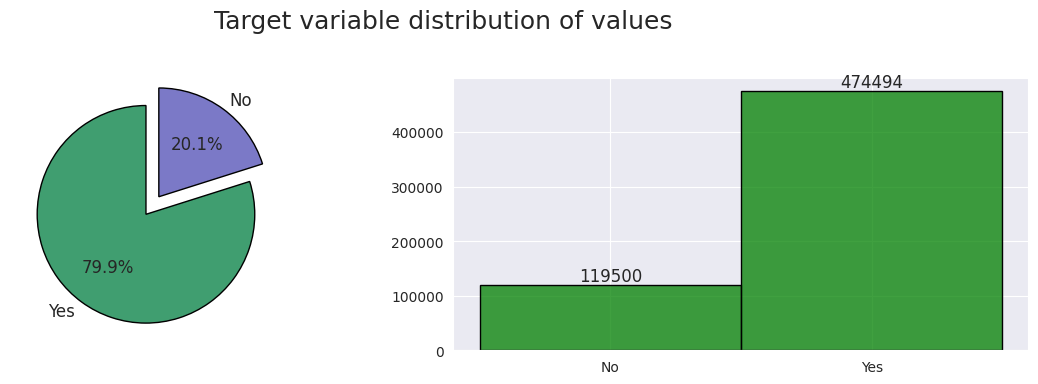

In [12]:
# We create a variable for the analysis

subscribe_to = lpb_train["loan_paid_back"].replace([0, 1], ["No", "Yes"]).astype("category")

# We print and graph the distribution

counts_t = subscribe_to.value_counts()
labels_t = counts_t.index
sizes_t = counts_t.values
color_t = ["#409e70", "#7b79c7"]
explode_t = (0.0, 0.2)
title_t = "Target variable distribution of values"

plot_categories(subscribe_to, (12, 4), sizes_t, labels_t, color_t, explode_t, title_t)

We found the classes unbalanced, with the majority of samples focused on customers paying back their loans, at almost 80%.

## Annual Income

Annual income is the total amount of money earned in a year, including salary, bonuses, and other sources like interest or tips. It is calculated as either gross annual income, which is your income before any deductions, or net annual income, which is your "take-home pay" after deductions like taxes and retirement contributions have been subtracted.

Variable:  annual_income 
Format:  float64 
Number of null values:  0 
Unique values:  119728 
Variable range: 6002.43 to 393381.74 




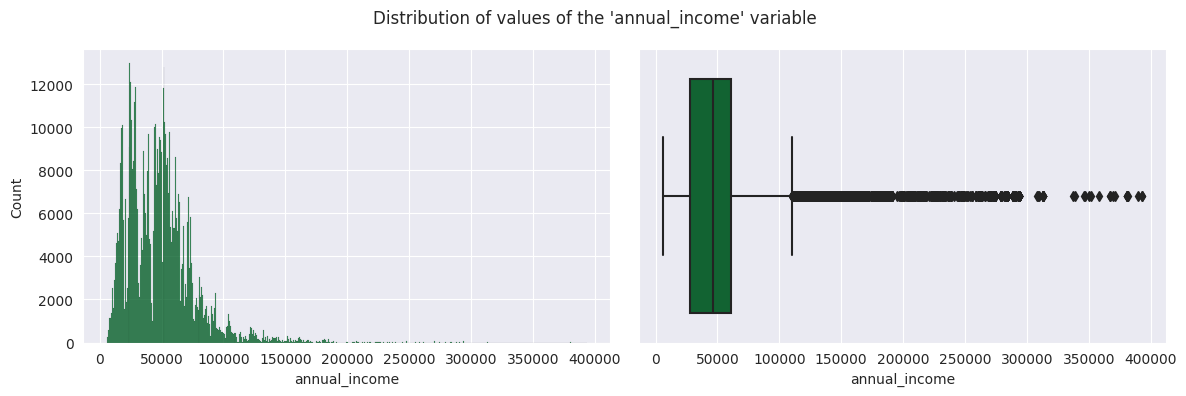

In [13]:
# We print and graph the distribution

plot_number_analyzer(
    lpb_train, 
    "annual_income", 
    (12, 4), 
    "Distribution of values of the 'annual_income' variable"
)

We are dealing with a continuous quantitative variable with a high cardinality, with values ranging from 6002.43 to 393381.74 and 119728 unique values. We found a distribution with a distribution skewed to the right with the presence of a very pronounced tail. Most values centered in the lower range. We observed a high number of outliers.

## Debt to Income Ratio

A debt-to-income (DTI) ratio is a personal finance metric that compares your total monthly debt payments to your gross monthly income. It is calculated by dividing your monthly debt by your monthly gross income and expressed as a percentage. Lenders use this ratio to assess your ability to repay borrowed money and whether you can manage additional debt, with lower DTI ratios being more favorable for loan approval.

Variable:  debt_to_income_ratio 
Format:  float64 
Number of null values:  0 
Unique values:  526 
Variable range: 0.011 to 0.627 




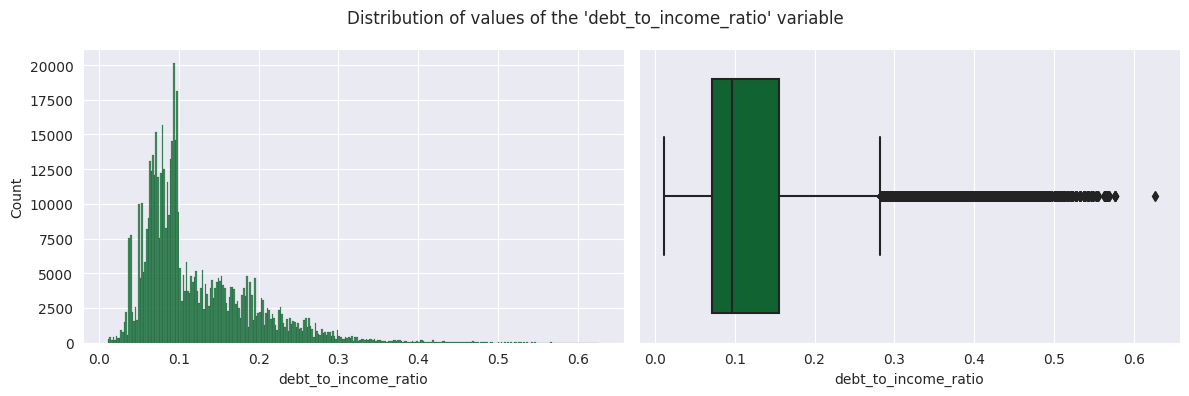

In [14]:
# We print and graph the distribution

plot_number_analyzer(
    lpb_train, 
    "debt_to_income_ratio", 
    (12, 4), 
    "Distribution of values of the 'debt_to_income_ratio' variable"
)

We found a distribution skewed to the right, with a range of values ​​from 0.011 to 0.627 and more than 500 unique values. The variable does not contain any null or erroneous values, but we did observe the presence of outliers that need to be addressed.

## Credit Score

A credit score is a three-digit number that assesses a person's creditworthiness based on their credit history. Financial institutions use it to decide whether to grant credit and under what terms. Higher scores indicate a greater likelihood of repaying a debt on time, which typically results in lower interest rates for loans and credit cards.

Key Factors That Influence Your Score

- Payment History: Paying your bills on time is the most important factor in maintaining a good score.

- Total Debt: The amount of debt you have compared to your available credit (credit utilization ratio) is a significant factor.

- Length of Credit History: A longer, more positive credit history generally helps your score.

- New Loans: Applying for too many loans in a short period can negatively affect your score.

Variable:  credit_score 
Format:  int64 
Number of null values:  0 
Unique values:  399 
Variable range: 395 to 849 




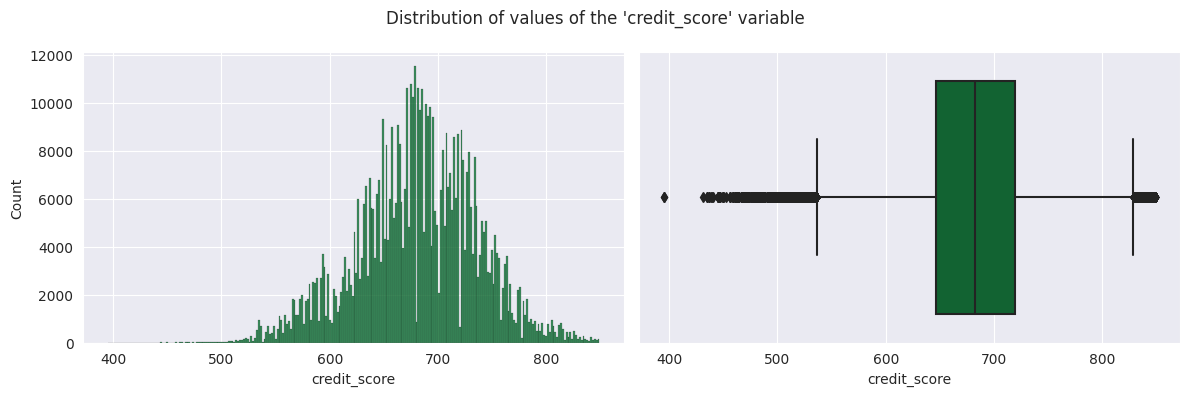

In [15]:
# We print and graph the distribution

plot_number_analyzer(
    lpb_train, 
    "credit_score", 
    (12, 4), 
    "Distribution of values of the 'credit_score' variable"
)

The variable does not contain any null or erroneous values. We can observe a slight tail to the left, but we find outliers in both the low and high ranges. The average score is 680, with most values ​​centered between 640 and 720 points.

## Loan Amount

The loan amount is the principal sum of money that is borrowed, also known as the principal. This initial amount, along with the interest rate and loan term, determines your total repayment cost, monthly payments, and how much you can borrow overall. It's important to borrow only the amount you need, as a higher loan amount can lead to a higher overall cost and higher monthly payments.

Variable:  loan_amount 
Format:  float64 
Number of null values:  0 
Unique values:  111570 
Variable range: 500.09 to 48959.95 




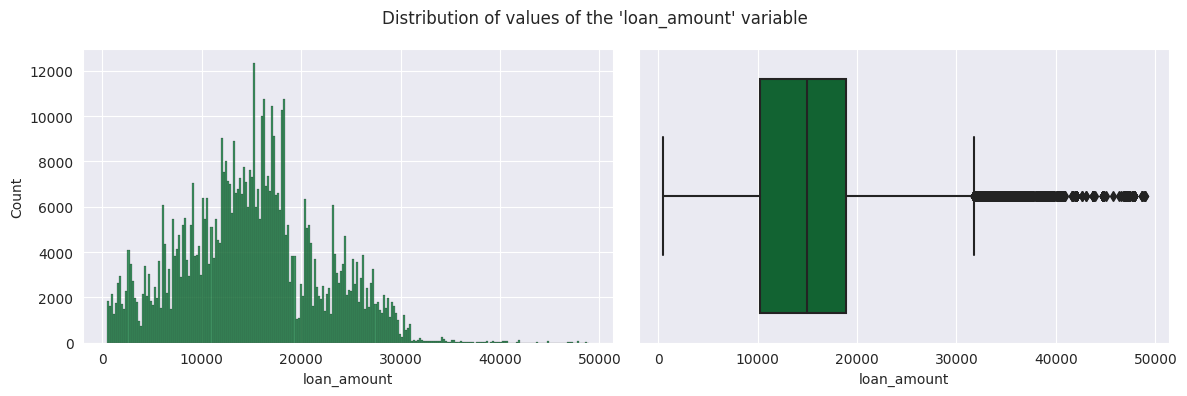

In [16]:
# We print and graph the distribution

plot_number_analyzer(
    lpb_train, 
    "loan_amount", 
    (12, 4), 
    "Distribution of values of the 'loan_amount' variable"
)

Once again, we encounter another high-cardinality quantitative continuous variable, with values ranging from 500.09 to 48959.95 and 111570 unique values. It exhibits a right-skewed distribution and outliers in the higher value range. The average loan amount is 15020. We found no null or erroneous values.

## Interest Rate

An interest rate is the amount of interest due per period, as a proportion of the amount lent, deposited, or borrowed.

Variable:  interest_rate 
Format:  float64 
Number of null values:  0 
Unique values:  1454 
Variable range: 3.2 to 20.99 




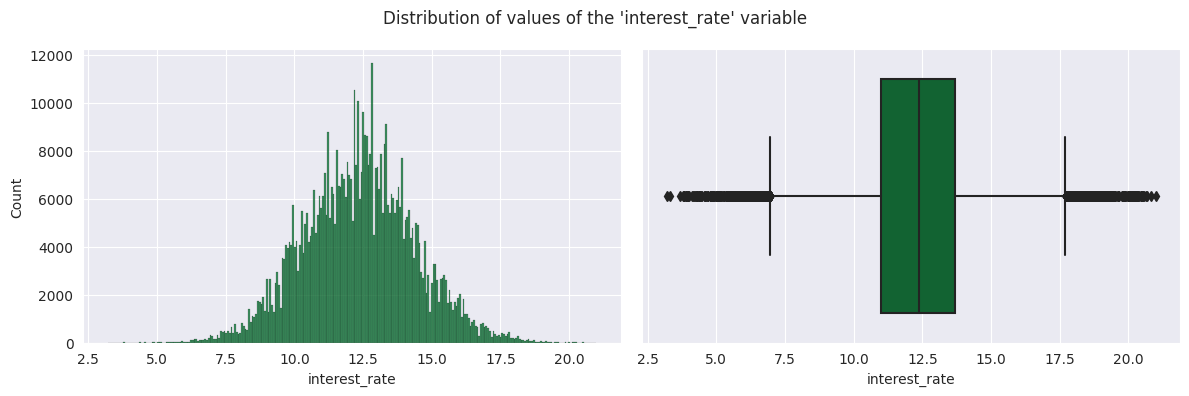

In [17]:
# We print and graph the distribution

plot_number_analyzer(
    lpb_train, 
    "interest_rate", 
    (12, 4), 
    "Distribution of values of the 'interest_rate' variable"
)

We observed a near-normal distribution centered in the middle range of values, but with outliers at both ends. We did not see any null or erroneous values. The range of values is between 3.2 and 20.99 with an average interest rate of 12.36.

## Gender

A "gender variable" refers to a term used to represent and analyze gender differences in a dataset, whether in research or statistics. It can be classified as a nominal categorical variable, since gender is divided into categories (such as male, female, non-binary, etc.) that have no inherent order. In practice, it can be coded as text or numbers to facilitate statistical analysis, but correctly labeling the categories is crucial for accurate interpretation.


Number of null values:  0 
Unique values:  3 
Distribution of values: 
 gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64 




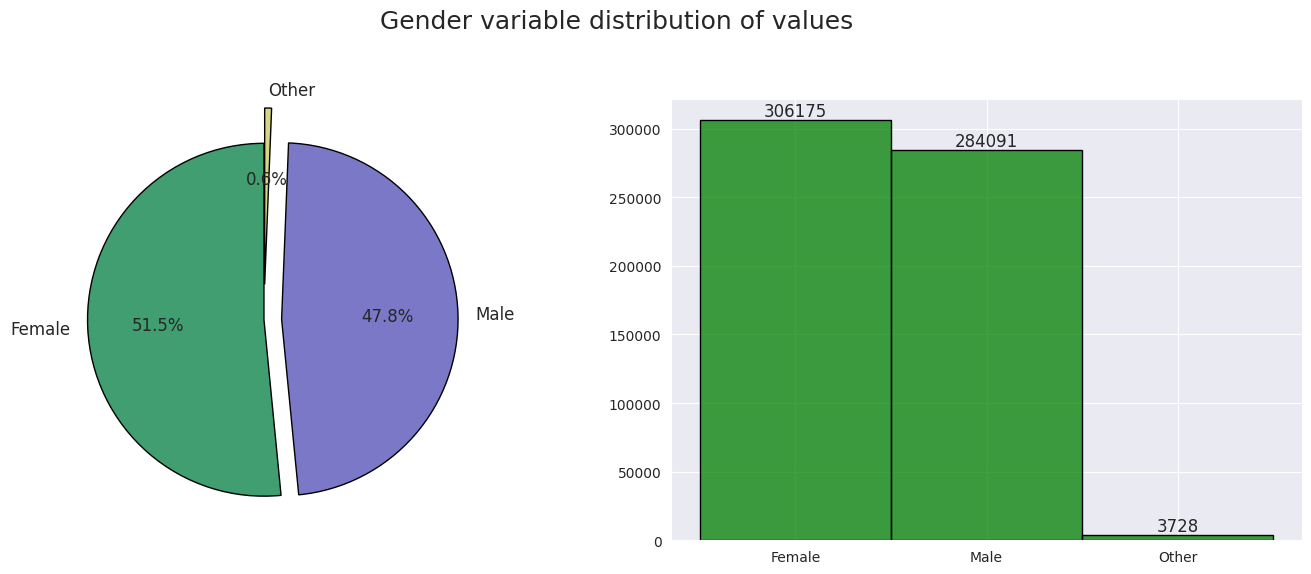

In [18]:
# We print and graph the distribution

counts_g = lpb_train["gender"].value_counts()
labels_g = counts_g.index
sizes_g = counts_g.values
color_g = ["#409e70", "#7b79c7", "#d7d684"]
explode_g = (0.0, 0.1, 0.2)
title_g = "Gender variable distribution of values"

plot_categories(lpb_train["gender"], (14, 6), sizes_g, labels_g, color_g, explode_g, title_g)

We have a categorical variable with three unique values representing gender. We do not observe any null or erroneous values, but we do have the presence of the "other" category, with very few samples that could be replaced by the average or, being 0.6% of the samples, we could discard them and convert the variable into a binary one.

## Marital Status

The marital status variable refers to a person's legal status in terms of marriage or registered partnership and is a nominal or ordinal scale variable that classifies people into categories such as single, married, divorced, widowed, or separated. There are different types of marital status variables, such as registered marital status, which focuses on the legal status of a registered marriage, or social marital status, which may include cohabitation agreements or common-law unions.


Number of null values:  0 
Unique values:  4 
Distribution of values: 
 marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64 




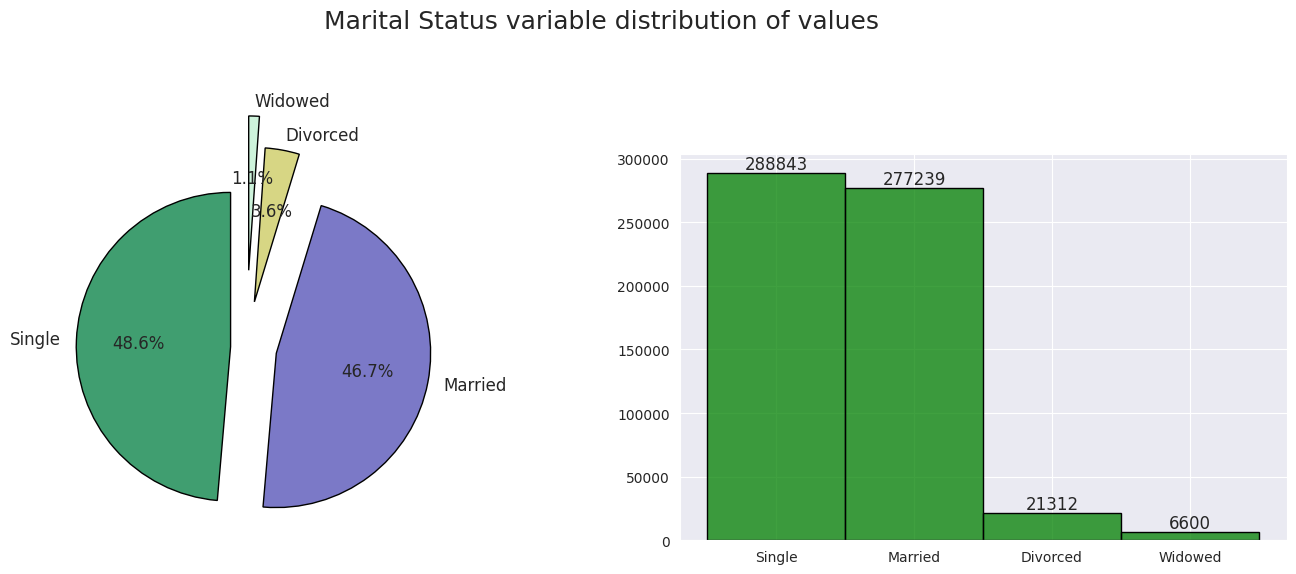

In [19]:
# We print and graph the distribution

counts_m = lpb_train["marital_status"].value_counts()
labels_m = counts_m.index
sizes_m = counts_m.values
color_m = ["#409e70", "#7b79c7", "#d7d684", "#cdf3db"]
explode_m = (0.1, 0.2, 0.3, 0.5)
title_m = "Marital Status variable distribution of values"

plot_categories(lpb_train["marital_status"], (14, 6), sizes_m, labels_m, color_m, explode_m, title_m)

We found no null or erroneous data. The variable has four unique values, with two of them representing more than 95% of the samples. This variable could be converted into a binary variable by replacing the values "Widowed" with "Married" and "Divorced" with "Single," although a more extensive analysis for this transformation would be necessary, analyzing both pairs together.

## Education Level

An education level variable is an ordinal categorical variable because it represents a distinct order or rank (like high school, bachelor's, master's), but the differences between the categories are not uniform or precisely measurable. It is used to categorize individuals based on their highest level of educational attainment, such as "less than high school," "high school graduate," or "advanced degree".


Number of null values:  0 
Unique values:  5 
Distribution of values: 
 education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64 




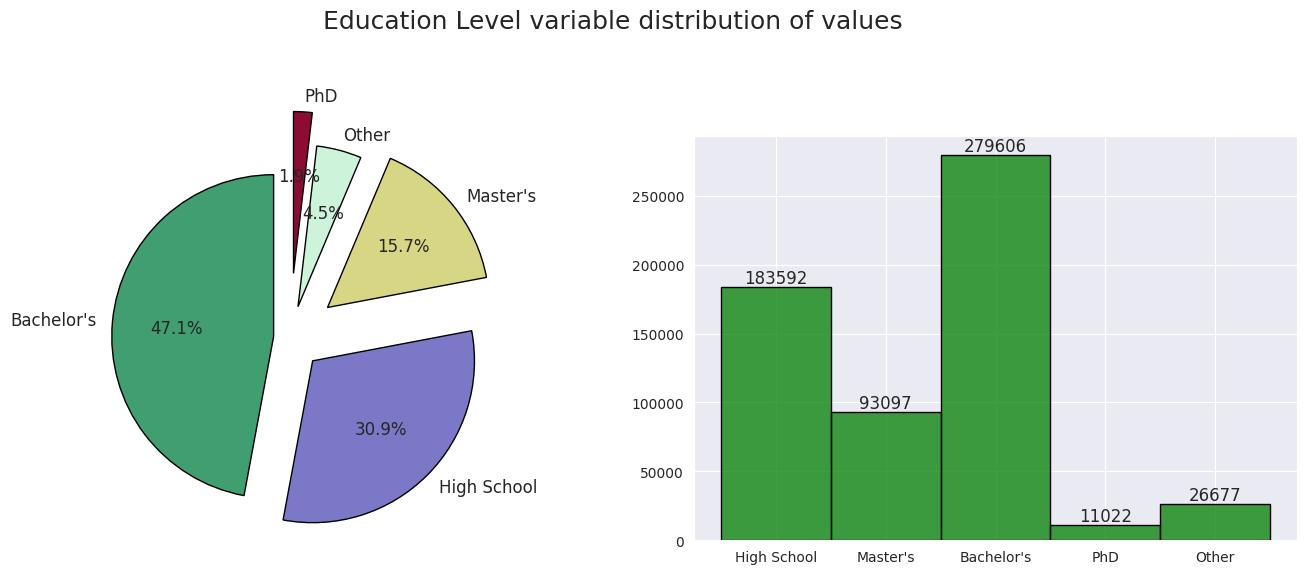

In [20]:
# We print and graph the distribution

counts_e = lpb_train["education_level"].value_counts()
labels_e = counts_e.index
sizes_e = counts_e.values
color_e = ["#409e70", "#7b79c7", "#d7d684", "#cdf3db", "#8d0c34"]
explode_e = (0.1, 0.2, 0.3, 0.2, 0.4)
title_e = "Education Level variable distribution of values"

plot_categories(lpb_train["education_level"], (14, 6), sizes_e, labels_e, color_e, explode_e, title_e)

The variable has five unique values, with three of them accounting for the largest number of samples. We could map the categories according to educational level. We could also use an ordinal encoder with category auto or a more advanced method like a target encoder. We found no null or erroneous values.

## Employment Status

An employment status variable is a categorical variable that describes a person's labor force participation, such as being employed, unemployed, or not in the labor force. These variables are used in social and economic research to categorize individuals based on their work status and are often used as an independent variable to analyze how employment affects other factors. Different studies or datasets will have their own specific variable names and detailed categories.


Number of null values:  0 
Unique values:  5 
Distribution of values: 
 employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64 




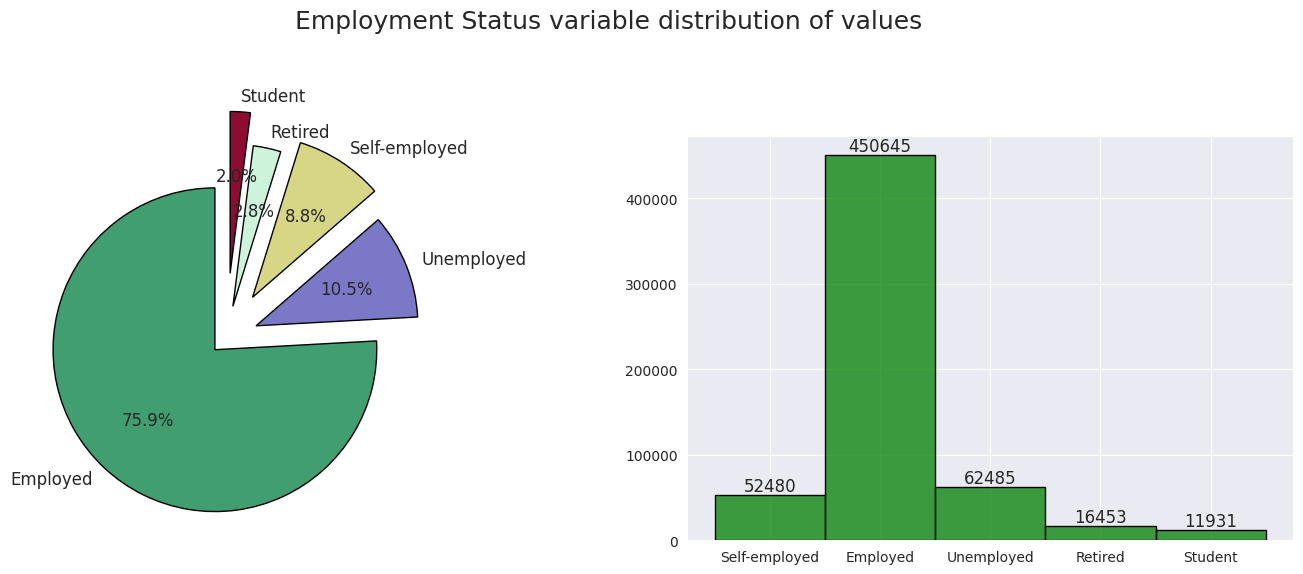

In [21]:
# We print and graph the distribution

counts_es = lpb_train["employment_status"].value_counts()
labels_es = counts_es.index
sizes_es = counts_es.values
color_es = ["#409e70", "#7b79c7", "#d7d684", "#cdf3db", "#8d0c34"]
explode_es = (0.1, 0.2, 0.3, 0.2, 0.4)
title_es = "Employment Status variable distribution of values"

plot_categories(lpb_train["employment_status"], (14, 6), sizes_es, labels_es, color_es, explode_es, title_es)

We again found a variable with five unique values, where only one class encompasses more than 75% of the samples. We could again map the classes to this variable or use the encoding techniques mentioned previously. We observed no null or erroneous data.

## Loan Purpose

Loan purpose is the specific reason why a borrower wants to take out a loan, such as buying a house, consolidating debt, or funding a home renovation. Lenders ask for this information to assess risk, determine the interest rate and loan terms, and to ensure the funds are not being used for illegal or prohibited activities. Some loans require a specific purpose (e.g., a mortgage for a house), while others are more flexible (e.g., a personal loan that can be used for various needs). Loan purpose is important to the process of obtaining mortgages or business loans that are connected with specific types of business activities. Pertaining to mortgages and their risk based pricing factors, the loan purpose factor is sub-categorized by purchase, rate and term refinance and cash-out refinance.


Number of null values:  0 
Unique values:  8 
Distribution of values: 
 loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64 




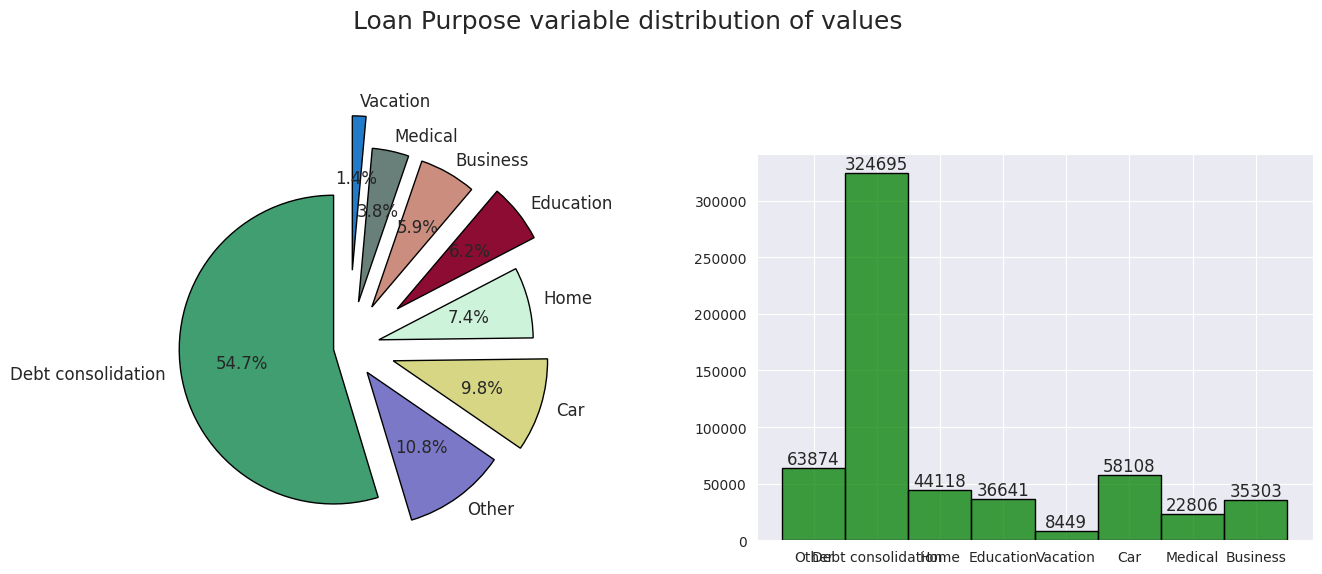

In [22]:
# We print and graph the distribution

counts_l = lpb_train["loan_purpose"].value_counts()
labels_l = counts_l.index
sizes_l = counts_l.values
color_l = ["#409e70", "#7b79c7", "#d7d684", "#cdf3db", "#8d0c34", "#ca8d7e", "#687f7a", "#227bc9"]
explode_l = (0.1, 0.2, 0.3, 0.2, 0.4, 0.3, 0.3, 0.5)
title_l = "Loan Purpose variable distribution of values"

plot_categories(lpb_train["loan_purpose"], (14, 6), sizes_l, labels_l, color_l, explode_l, title_l)

We found a total of eight unique values, with the "debt consolidation" class representing almost 55% of the samples. Applying an encoder to handle this variable would be the most appropriate approach, as mapping it would require establishing an order, which would mean defining the risk level of each class of loan to assign the appropriate weight to each. The variable contains no null or erroneous data.

## Grade Subgrade

Loan grade and subgrade represent the risk associated with a loan, with higher grades (e.g., A1) indicating lower risk and lower grades (e.g., G5) indicating higher risk. These grades are determined by a variety of factors, including the borrower's credit history, income, debt-to-income ratio, and the loan's specific terms. Subgrades provide more detailed risk differentiation within a main grade, so A1 is the lowest risk possible, while A5 is riskier than A1 but lower risk than B1.

How they are determined

- Credit history: A borrower's credit score and credit report are primary factors.
- Financial ratios: The debt-to-income ratio is a key metric.
- Loan-specific factors: For some loans, the ratio of the loan amount to the property's value (Loan-to-ARV) can be a factor.
- Collateral: The presence and value of collateral can also influence the grade. 


Number of null values:  0 
Unique values:  30 




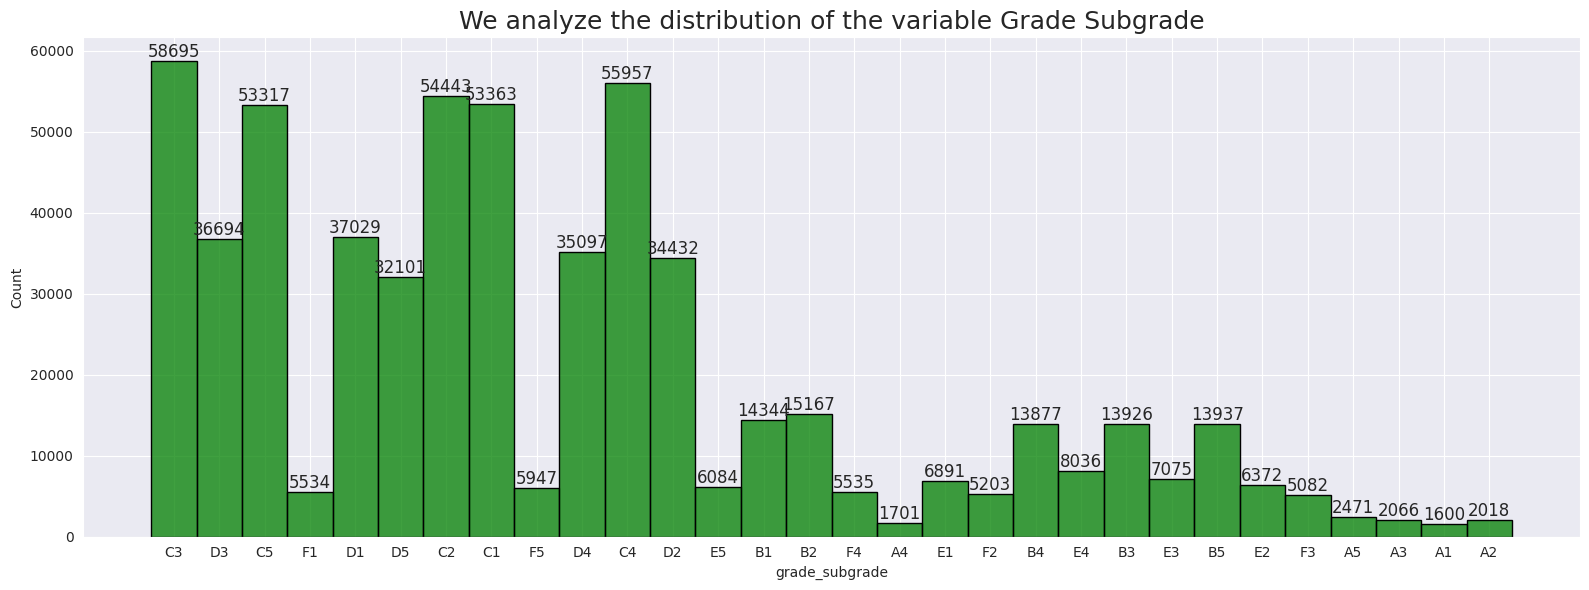

In [23]:
# We print the general information of the variable

print(
    "\nNumber of null values: ", lpb_train["grade_subgrade"].isnull().sum(),
    "\nUnique values: ", lpb_train["grade_subgrade"].nunique(), "\n\n"
    )

# We analyze the distribution

fig, axes = plt.subplots(figsize=(16, 6))

g = sns.histplot(
    data=lpb_train, 
    x="grade_subgrade", 
    color="green",
    edgecolor="k"
)

# Add labels with the exact value above each bar
    
for container in g.containers:
    g.bar_label(container, fontsize=12)

plt.title(label="We analyze the distribution of the variable Grade Subgrade", fontsize=18)
plt.tight_layout()
plt.show()

We have a categorical variable with very high cardinality, containing a total of 30 unique values. Representing different levels of loan risk, it could be mapped, assigning each respective risk level its appropriate weight. We could also use a more advanced method such as target encoding. The variable contains no null or erroneous values.

We have completed our exploratory data analysis. Next, we will perform a simple data manipulation process to extend the analysis in more depth, posing some questions of interest.